# Sequential Workflow Experiment

In [1]:
import json
import os
import pdb
import random
import re
import time
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import PIL
import requests
from diskcache import Cache
from openai import OpenAI
from PIL import Image
from termcolor import colored

import autogen
from autogen import Agent, AssistantAgent, ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.img_utils import _to_pil, get_image_data, get_pil_image, gpt4v_formatter
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent

In [2]:
config_list_4v = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4o"],
    },
)

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4o"],
    },
)

config_list_dalle = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["dalle"],
    },
)

gpt4_llm_config = {"config_list": config_list_gpt4, "cache_seed": 42}

In [3]:
def dalle_call(client: OpenAI, model: str, prompt: str, size: str, quality: str, n: int) -> str:
    # Function implementation...
    cache = Cache(".cache/")  # Create a cache directory
    key = (model, prompt, size, quality, n)
    if key in cache:
        return cache[key]

    # If not in cache, compute and store the result
    response = client.images.generate(
        model=model,
        prompt=prompt,
        size=size,
        quality=quality,
        n=n,
    )
    image_url = response.data[0].url
    img_data = get_image_data(image_url)
    cache[key] = img_data

    return img_data

In [4]:
def extract_img(agent: Agent) -> PIL.Image:
    last_message = agent.last_message()["content"]

    if isinstance(last_message, str):
        img_data = re.findall("<img (.*)>", last_message)[0]
    elif isinstance(last_message, list):
        # The GPT-4V format, where the content is an array of data
        assert isinstance(last_message[0], dict)
        img_data = last_message[0]["image_url"]["url"]

    pil_img = get_pil_image(img_data)
    return pil_img

In [5]:
class DALLEAgent(ConversableAgent):
    def __init__(self, name, llm_config: dict, **kwargs):
        super().__init__(name, llm_config=llm_config, **kwargs)

        try:
            config_list = llm_config["config_list"]
            api_key = config_list[0]["api_key"]
        except Exception as e:
            print("Unable to fetch API Key, because", e)
            api_key = os.getenv("OPENAI_API_KEY")
        self._dalle_client = OpenAI(api_key=api_key)
        self.register_reply([Agent, None], DALLEAgent.generate_dalle_reply)

    def send(
        self,
        message: Union[Dict, str],
        recipient: Agent,
        request_reply: Optional[bool] = None,
        silent: Optional[bool] = False,
    ):
        super().send(message, recipient, request_reply, silent=True)

    def generate_dalle_reply(self, messages: Optional[List[Dict]], sender: "Agent", config: Optional[Dict]):
        client = self._dalle_client if config is None else config
        if client is None:
            return False, None
        if messages is None:
            messages = self._oai_messages[sender]

        prompt = messages[-1]["content"]
        img_data = dalle_call(
            client=client,
            model="dall-e-3",
            prompt=prompt,
            size="1024x1024",
            quality="standard",
            n=1,
        )

        img_data = _to_pil(img_data)  # Convert to PIL image

        return True, {"content": [{"type": "image_url", "image_url": {"url": img_data}}]}

In [6]:
class DALLESituationAgent(ConversableAgent):
    def __init__(self, name, llm_config: dict, **kwargs):
        super().__init__(name, llm_config=llm_config, **kwargs)

        try:
            config_list = llm_config["config_list"]
            api_key = config_list[0]["api_key"]
        except Exception as e:
            print("Unable to fetch API Key, because", e)
            api_key = os.getenv("OPENAI_API_KEY")
        self._dalle_client = OpenAI(api_key=api_key)
        self.register_reply([Agent, None], DALLESituationAgent.generate_dalle_reply)

    def send(
        self,
        message: Union[Dict, str],
        recipient: Agent,
        request_reply: Optional[bool] = None,
        silent: Optional[bool] = False,
    ):
        super().send(message, recipient, request_reply, silent=True)

    def generate_dalle_reply(self, messages: Optional[List[Dict]], sender: "Agent", config: Optional[Dict]):
        client = self._dalle_client if config is None else config
        if client is None:
            return False, None
        if messages is None:
            messages = self._oai_messages[sender]

        prompt = messages[-1]["content"]
        img_data = dalle_call(
            client=client,
            model="dall-e-3",
            prompt=prompt,
            size="1024x1024",
            quality="hd",
            n=1,
        )

        img_data = _to_pil(img_data)  # Convert to PIL image

        # Return the OpenAI message format
        return True, {"content": [{"type": "image_url", "image_url": {"url": img_data}}]}

In [7]:
class DalleCreator(AssistantAgent):
    def __init__(self, n_iters=2, **kwargs):
        super().__init__(**kwargs)
        self.register_reply([Agent, None], reply_func=DalleCreator._reply_user, position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)  # noqa: F821
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        img_prompt = messages[-1]["content"]

        # Define the agents
        self.ConceptAgent = ConversableAgent(
            name="ConceptAgent",
            system_message="""
            You are an experienced character designer specialized in creating innovative and engaging character concepts.

            ### Instruction:
            Your task is to create an appealing and detailed character concept based on the initial prompt. Your output should include:

            - **Backstory**: Craft a detailed backstory for the character, including their origins, key life events, significant relationships, hobbies, and any unique experiences that shaped their personality.
            - **Personality Traits**: Determine descriptors like brave, comical, shy, and adventurous that will influence their actions and dialogue.
            - **Motivations**: Establish the driving goals, desires, and conflicts that propel the character through the story. Motivations inform their arc.
            - **Mannerisms**: Come up with signature habitual behaviors, gestures, postures, and quirks that reflect personality.

            ### Format:
            - Personality Traits: 
            - Backstory:
            - Motivations:
            - Mannerisms: 

            """,
            llm_config={"config_list": config_list_4v, "max_tokens": 1000},
            human_input_mode="NEVER",
            max_consecutive_auto_reply=3,
        )
        self.SketchAgent = DALLEAgent(
            name="SketchAgent", 
            system_message="""
            You are an experienced character designer with a focus on creating detailed and engaging character sketches based on concepts provided by ConceptAgent.

### Instruction:
Your task is to create black-and-white sketches of the character, emphasizing the essential silhouette, pose, and personality. Your sketches should include the following views:

1. **Full ‘A’ pose view (head to toe)**: Capture the character's overall form, ensuring the pose clearly communicates their personality.
2. **Orthographic front view**: Provide a clear and accurate representation of the character from the front, focusing on key details and proportions.
3. **Orthographic back view**: Show the character from the back, maintaining consistency with the front view while highlighting any distinctive features.

### Additional Notes:
- Ensure that the sketches are clean and focus on defining the character’s essential visual traits.
- Prioritize clarity and detail, especially in the silhouette and proportions, to ensure that the character’s design is easily understandable from all angles.
            """,
            llm_config={"config_list": config_list_dalle}, max_consecutive_auto_reply=0
        )

        self.ColorAgent = DALLEAgent(
            name="ColorAgent", 
            system_message="""
You are a skilled character designer specializing in adding color to character sketches. Your task is to enhance the character sketches provided by SketchAgent with a carefully chosen color palette.

### Requirements:
1. **Color Selection**: Choose 3-5 core colors that not only reflect the character’s personality, backstory, and role but also enhance their visual impact.
2. **Silhouette Recognition**: Ensure that the selected colors improve the character’s silhouette recognition, making them distinct and easily identifiable.
3. **Balance and Flexibility**: The color scheme should balance distinctiveness with flexibility, allowing for effective rendering in different lighting conditions and environments.

### Output:
Your final output should include the following colored views:

1. **Colored Full ‘A’ Pose View (head to toe)**: Apply the color palette to the full-body view, ensuring that the colors highlight the character's essential features and personality.
2. **Colored Orthographic Front View**: Add color to the front view, focusing on maintaining consistency with the full pose while emphasizing key details.
3. **Colored Orthographic Back View**: Apply the color scheme to the back view, ensuring continuity with the front and full pose views.

### Additional Notes:
- Prioritize color combinations that enhance the character's overall design and visual storytelling.
- Ensure that the final colors are not only aesthetically pleasing but also functional, supporting the character's narrative and role within their story.
            """,
            llm_config={"config_list": config_list_dalle}, max_consecutive_auto_reply=0,
        )

        self.RefineAgent = DALLESituationAgent(
            name="RefineAgent", 
            system_message="""
            You are a skilled character designer focused on refining and enhancing character details to achieve the highest quality and consistency across all views.

### Requirements:
1. **Consistency**: Ensure the character's design is consistent across all views (full 'A' pose, front, and back), with no discrepancies in proportions, colors, or details.
2. **Detail Enhancement**: Refine and enhance subtle details and nuances to improve the character's overall visual quality and appeal, such as textures, shading, and fine features.
3. **Clean Output**: Ensure the final images are clean, with no words, text, or unintended artifacts present.

### Output:
Your refined output should include the following colored views, with enhanced details and consistency:

1. **Colored Full ‘A’ Pose View (head to toe)**: Refine the full-body view, ensuring that all details are cohesive and contribute to the character’s overall quality.
2. **Colored Orthographic Front View**: Ensure consistency and enhance the front view, focusing on maintaining detail accuracy and quality.
3. **Colored Orthographic Back View**: Refine the back view to match the quality and detail level of the other views, ensuring seamless consistency.

### Additional Notes:
- Pay special attention to the alignment and proportion of details across all views to ensure a uniform and polished final design.
- Focus on enhancing elements that will elevate the character's visual impact, ensuring that the design is both functional and aesthetically pleasing.
            """,
            llm_config={"config_list": config_list_dalle}, max_consecutive_auto_reply=0,
        )

#         self.SituationTextAgent = ConversableAgent(
#             name="SituationTextAgent",
#             system_message="""You are responsible for generating various poses and situations for the character, consistent with their personality and backstory.
    
# Requirements:
# 1. Create scenarios that vividly portray the character.
# 2. Ensure the situations align with the character's established traits and motivations.
#             """,
#             llm_config={"config_list": config_list_4v, "max_tokens": 1000},
#             human_input_mode="NEVER",
#             max_consecutive_auto_reply=3,
#         )

#         self.SituationImgAgent = DALLEAgent(
#             name="SituationImgAgent", 
#             system_message="""You are responsible for generating images of the character based on the situations provided by SituationTextAgent.
    
# Requirements:
# 1. Ensure high consistency in the character's appearance and details provided from the input image.
# 2. Accurately depict the character in the specified scenarios, reflecting their personality and backstory.
# 3. Ensure there are no words or text in the image.
#             """,
#             llm_config={"config_list": config_list_dalle}, max_consecutive_auto_reply=0,
#         )

        self.SituationAgent = DALLESituationAgent("""
You are an experienced character designer specializing in creating dynamic poses and situations that align with the character’s storyline.

### Requirements:
1. **Consistency**: Maintain high consistency in the character’s appearance and details as provided by RefineAgent. Ensure that all visual elements align with the input image.
2. **Scenario Accuracy**: Depict the character in scenarios that accurately reflect their personality, backstory, and role within the story. The poses and situations should be expressive and true to the character's nature.
3. **Clean Output**: Ensure the final images are free of any words, text, or unintended artifacts.

### Output:
Your output should include multiple character poses and situations that are consistent with the character's design and narrative.

### Additional Notes:
- Pay special attention to the character's body language and expressions to ensure they convey the intended emotions and story context.
- Ensure that the scenarios are visually engaging and enhance the overall narrative of the character.
                """,
            llm_config={"config_list": config_list_dalle}, max_consecutive_auto_reply=0,
        )

        # self.TestAgent = DALLEAgent(
        #     name="TestAgent", 
        #     system_message="""You need to identify and remove images that could disrupt the consistency of the character, 
        #     such as imprecise details or significant variations.
        #     """,
        #     llm_config={"config_list": config_list_dalle}, max_consecutive_auto_reply=0,
        # )

        # Step 1: Generate character concept
        concept_prompt = f"""{img_prompt} Create a character concept based on the prompt provided."""
        self.send(message={"content": concept_prompt, "system_message": self.ConceptAgent.system_message}, recipient=self.ConceptAgent, request_reply=True)
        concept_response = self._oai_messages[self.ConceptAgent][-1]["content"]

        # Step 2: Generate two different character sketches based on different interpretations of the concept
        # Step 2.1: Generate first sketch with one interpretation of the concept
        sketch_prompt_1 = f"""{concept_response} 
        Create a black-and-white sketch of the character. Interpret the concept creatively, emphasizing one potential visual direction for the character.
        The character should be in full ‘A’ pose view (head to toe), as well as an orthographic front and back view of it. 
        Focus on accurately capturing this version of the character's overall design and proportions."""
        self.send(message={"content": sketch_prompt_1, "system_message": self.SketchAgent.system_message}, recipient=self.SketchAgent, request_reply=True)
        sketch_img_1 = extract_img(self.SketchAgent)
        sketch_img_1.save("sketch_image_1.png")

        # Display first sketch
        plt.imshow(sketch_img_1)
        plt.title("Sketch Image 1")
        plt.axis("off")
        plt.show()

        # Step 2.2: Generate second sketch with another interpretation of the concept
        sketch_prompt_2 = f"""{concept_response} 
        Create a black-and-white sketch of the character. This time, interpret the concept in a different way, exploring an alternative visual direction for the character.
        The character should be in full ‘A’ pose view (head to toe), as well as an orthographic front and back view of it. 
        Focus on accurately capturing this alternative version of the character's overall design and proportions."""
        self.send(message={"content": sketch_prompt_2, "system_message": self.SketchAgent.system_message}, recipient=self.SketchAgent, request_reply=True)
        sketch_img_2 = extract_img(self.SketchAgent)
        sketch_img_2.save("sketch_image_2.png")

        # Display second sketch
        plt.imshow(sketch_img_2)
        plt.title("Sketch Image 2")
        plt.axis("off")
        plt.show()

        # Step 3: Add colors to the skecthes
        # Critique and select the best sketch based on the concept
        critique_prompt = f"""{concept_response} 
        You have two different black-and-white sketches of the character:
        1. Sketch Image 1: <img sketch_image_1.png>
        2. Sketch Image 2: <img sketch_image_2.png>
        Evaluate both sketches and select the one that best represents the concept. 
        After selecting the best sketch, apply two different color schemes to it to explore different visual identities."""
        self.send(message={"content": critique_prompt, "system_message": self.ColorAgent.system_message}, recipient=self.ColorAgent, request_reply=True)
        selected_sketch = extract_img(self.ColorAgent)
        selected_sketch.save("selected_sketch.png")

        # Display the selected sketch
        plt.imshow(selected_sketch)
        plt.title("Selected Sketch")
        plt.axis("off")
        plt.show()

        # First color scheme
        color_prompt_1 = f"""Based on the concept and the selected sketch <img selected_sketch.png>, 
        apply the first color scheme that enhances the character's appearance and contributes to the overall visual identity."""
        self.send(message={"content": color_prompt_1, "system_message": self.ColorAgent.system_message}, recipient=self.ColorAgent, request_reply=True)
        color_img_1 = extract_img(self.ColorAgent)

        # Save and display the first colored image
        color_img_1.save("color_image_1.png")
        plt.imshow(color_img_1)
        plt.title("Color-focused Image 1")
        plt.axis("off")
        plt.show()

        # Second color scheme
        color_prompt_2 = f"""Based on the concept and the selected sketch <img selected_sketch.png>, 
        apply a second color scheme that provides an alternative visual identity, offering a different interpretation of the character's design."""
        self.send(message={"content": color_prompt_2, "system_message": self.ColorAgent.system_message}, recipient=self.ColorAgent, request_reply=True)
        color_img_2 = extract_img(self.ColorAgent)

        # Save and display the second colored image
        color_img_2.save("color_image_2.png")
        plt.imshow(color_img_2)
        plt.title("Color-focused Image 2")
        plt.axis("off")
        plt.show()

        # Step 4: Refine the quality and details of the character
        refine_prompt = f""" 
        {concept_response} Refine the details and nuances of the character showed in the following image: <img color_image.png> and generate the refined version of the character.
        Ensure precise consistency and high quality aligned with the overall visual identity.
        """
        self.send(message={"content": refine_prompt, "system_message": self.RefineAgent.system_message}, recipient=self.RefineAgent, request_reply=True)
        refine_img = extract_img(self.RefineAgent)

        refine_img.save("refine_img.png")
        plt.imshow(refine_img)
        plt.title("Refine Image")
        plt.axis("off")
        plt.show()

        # Step 5: Generate different poses and situations
        situation_prompt = f"""
        Generate six different poses and situations of the character in the following image <img refine_img.png> based on the concept: {concept_response}. 
        Ensure the character should stay precise consistency and high quality aligned with the concept.
        """
        self.send(message={"content": situation_prompt, "system_message": self.SituationAgent.system_message}, recipient=self.SituationAgent, request_reply=True)
        situation_img = extract_img(self.SituationAgent)
        situation_img.save("situation_img.png")
        plt.imshow(situation_img)
        plt.title("Situation Image")
        plt.axis("off")
        plt.show()

        # Step 5: Generate different poses and situations
        # for i in range(self._n_iters):
        #     situation_text_prompt = f"""Generate one situation of the character in the following image <img refine_img.png> based on the concept: {concept_response}.
        #     Please use simple word and keep the description under 100 words"""
        #     self.send(message={"content": situation_text_prompt, "system_message": self.SituationTextAgent.system_message}, recipient=self.SituationTextAgent, request_reply=True)
        #     feedback = self._oai_messages[self.SituationTextAgent][-1]["content"]
        #     situation_img_prompt = f"""Apply the character in the following image <img refine_img.png> into the situation:{feedback}.
        #     Ensure the character is consistent with that in image and accurately depicted in the specified scenario.
        #     Ensure there are no words or text in the image.
        #     """
        #     self.send(message={"content": situation_img_prompt, "system_message": self.SituationImgAgent.system_message}, recipient=self.SituationImgAgent, request_reply=True)
        #     situation_img = extract_img(self.SituationImgAgent)
        #     situation_img.save(f"situation_img_{i}.png")
        #     plt.imshow(situation_img)
        #     plt.title(f"Situation Image {i}")
        #     plt.axis("off")
        #     plt.show()
        #     print(f"Image {i} PLOTTED")

        return True, "result.jpg"

User (to DALLE Creator!):

Design an elf cartoon style.

--------------------------------------------------------------------------------
DALLE Creator! (to ConceptAgent):

Design an elf cartoon style. Create a character concept based on the prompt provided.

--------------------------------------------------------------------------------
ConceptAgent (to DALLE Creator!):

### Character Concept: Finnan Leafwhisper

#### Personality Traits:
- Cheerful
- Inquisitive
- Diplomatic
- Loyal
- Adventurous

#### Backstory:
Finnan Leafwhisper hails from the enchanting Silverwood Forest, a hidden and mystical realm where elves live in harmony with nature. Born to an esteemed family of herbalists and healers, Finnan's childhood was spent learning the secrets of plants and potions. His parents, Elda and Theron Leafwhisper, are well-known in the community for their extensive knowledge of herbal lore and their involvement in the forest's protection.

Finnan has always been curious and adventurous, o

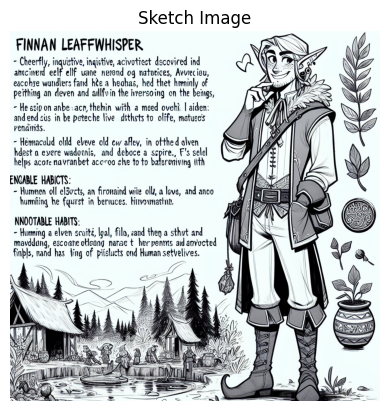

DALLE Creator! (to ColorAgent):

### Character Concept: Finnan Leafwhisper

#### Personality Traits:
- Cheerful
- Inquisitive
- Diplomatic
- Loyal
- Adventurous

#### Backstory:
Finnan Leafwhisper hails from the enchanting Silverwood Forest, a hidden and mystical realm where elves live in harmony with nature. Born to an esteemed family of herbalists and healers, Finnan's childhood was spent learning the secrets of plants and potions. His parents, Elda and Theron Leafwhisper, are well-known in the community for their extensive knowledge of herbal lore and their involvement in the forest's protection.

Finnan has always been curious and adventurous, often wandering beyond the well-trodden paths of Silverwood in search of new plants and hidden secrets. One such exploration led him to an ancient tree with unusual markings, which revealed a hidden entrance to an underground network of caves. Inside, Finnan discovered an ancient elf artifact said to be linked to the world's natural balance, 

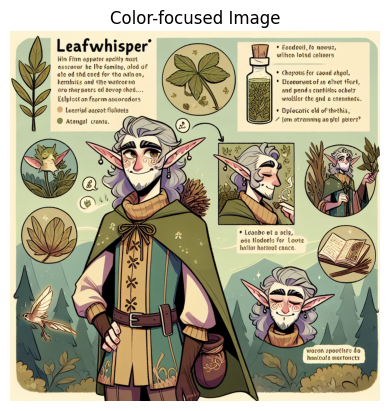

DALLE Creator! (to RefineAgent):

 
        ### Character Concept: Finnan Leafwhisper

#### Personality Traits:
- Cheerful
- Inquisitive
- Diplomatic
- Loyal
- Adventurous

#### Backstory:
Finnan Leafwhisper hails from the enchanting Silverwood Forest, a hidden and mystical realm where elves live in harmony with nature. Born to an esteemed family of herbalists and healers, Finnan's childhood was spent learning the secrets of plants and potions. His parents, Elda and Theron Leafwhisper, are well-known in the community for their extensive knowledge of herbal lore and their involvement in the forest's protection.

Finnan has always been curious and adventurous, often wandering beyond the well-trodden paths of Silverwood in search of new plants and hidden secrets. One such exploration led him to an ancient tree with unusual markings, which revealed a hidden entrance to an underground network of caves. Inside, Finnan discovered an ancient elf artifact said to be linked to the world's natura

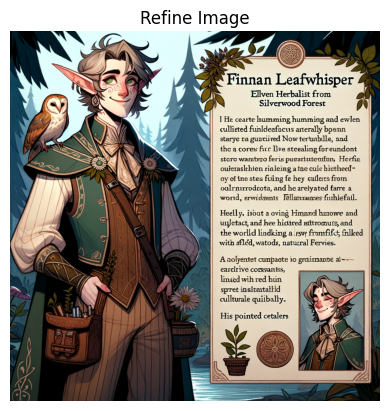

DALLE Creator! (to 
You are an experienced character designer specializing in creating dynamic poses and situations that align with the character’s storyline.

### Requirements:
1. **Consistency**: Maintain high consistency in the character’s appearance and details as provided by RefineAgent. Ensure that all visual elements align with the input image.
2. **Scenario Accuracy**: Depict the character in scenarios that accurately reflect their personality, backstory, and role within the story. The poses and situations should be expressive and true to the character's nature.
3. **Clean Output**: Ensure the final images are free of any words, text, or unintended artifacts.

### Output:
Your output should include multiple character poses and situations that are consistent with the character's design and narrative.

### Additional Notes:
- Pay special attention to the character's body language and expressions to ensure they convey the intended emotions and story context.
- Ensure that the scen

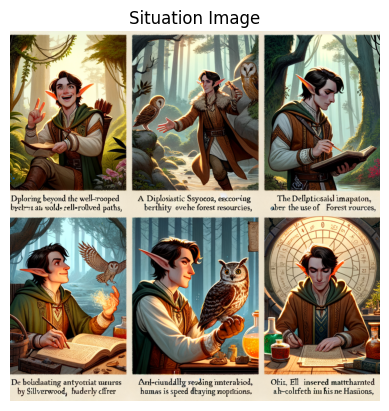

DALLE Creator! (to User):

result.jpg

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'Design an elf cartoon style.', 'role': 'assistant'}, {'content': 'result.jpg', 'role': 'user'}], summary='result.jpg', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

In [8]:
creator = DalleCreator(
    name="DALLE Creator!",
    max_consecutive_auto_reply=0,
    system_message="Help me coordinate generating image",
    llm_config=gpt4_llm_config,
)

user_proxy = UserProxyAgent(name="User", human_input_mode="NEVER", max_consecutive_auto_reply=0)

user_proxy.initiate_chat(
    creator, message="""Design an elf cartoon style."""
)